# JUALE
The next algorithm I make an extensive analysis of the effect of curvature, for this I try 1442 ways to approximate the free energy of solatation from the geometry of 502 species of solutes (molecules).

## 1. Importing libraries and defining functions

In [1]:
%reset -f
try:
    import trimesh
except:
    import pip
    pip.main(['install','trimesh'])
    import trimesh

import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)     
pi=np.pi
import os
import scipy
from scipy import stats


curvatura=["bf_esf","bf_cci","mc"]
panel_vert=["vert_456","vert_AWPN","panel"]
tipo_area=["a/3","a_mix","a_panel"]
tipo_tolman=["spc","spce"\
             ,"cte_gnp","p1_ponderado_gnp","p1_promedio_gnp","p1_mesh_ponderado_gnp","p1_mesh_promedio_gnp"\
             ,"cte_cav","p1_ponderado_cav","p1_promedio_cav","p1_mesh_ponderado_cav","p1_mesh_promedio_cav"]# agregar promedio tolamn =1.4
area_cs_s=["area_c_s","area_s_s"]
radio_tolman_cs_s=["radio_tolman_c_s","radio_tolman_s_s"]
mag_cs_s=["mag_c_s","mag_s_s"]

menu=np.array([curvatura,panel_vert,tipo_area,tipo_tolman,area_cs_s,radio_tolman_cs_s,mag_cs_s])

direct=os.getcwd()+"/mobley_test"

especies=open(direct+"/actually_all_names.txt", "r").read().split("\n")
especies.remove("ammonia"),especies.remove("hydrogen_sulfide") #229 341
especies=[i for i in especies if i!=""]
nominales=(open(direct+"/mobley_results_clean.txt", "r").read().split("\n"))
nominales=[i for i in nominales if i!=""];nominales=np.delete(np.float_(nominales),[229,341])
n_especies=len(especies)

nominales2=(open(direct+"/vdw_energy_d20.txt", "r").read().split("\n"))
nominales2=[i for i in nominales2 if i!=""];nominales2=np.delete(np.float_(nominales2),[229,341])

nominales2=nominales-nominales2

def txttoarray(especie,filename):
    file = open(direct+"/"+especie+"/"+filename+".txt", "r").read().split("\n")
    datos=[]
    for i in range(len(file)):
        datos.append(file[i].split())
    return(datos)

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def signo_dot(v1,v2):
    v11=unit_vector(v1)
    v22=unit_vector(v2)
    producto_punto=np.dot(v11,v22)
    if producto_punto>0:
        return(+1)
    else:
        return(-1)
def signo_dot2(v1,v2):
    if v1.shape!=v2.shape:
        print("no va funcionar, tienen formas distintas")
    else:
        s=np.zeros(len(v1))
        for i in range(len(v1)):
            v11=unit_vector(v1[i])
            v22=unit_vector(v2[i])
            producto_punto=np.dot(v11,v22)
            if producto_punto>0:
                s[i]=1
            else:
                s[i]=-1
        return s
    
def normie(vector):
    return np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def cotg(ang):
    return(1/np.tan(ang))



################ DATOS COMUNES ###############

tension_spc=65e-3
tension_spce=72e-3
def tolman_spce_p1(R):
    return(0.1873*R+0.3986)
def tolman_spc_p1(R):
    return(0.1245*R + 0.5208)
presion=101300 #PA
kcal=4184
avogadro=6.022140758e23
convert=avogadro/kcal

shapely.geometry.Polygon not available!
Traceback (most recent call last):
  File "C:\Users\juaco\Anaconda3\lib\site-packages\trimesh\creation.py", line 22, in <module>
    from shapely.geometry import Polygon
ModuleNotFoundError: No module named 'shapely'


## 2. Development and data recording
Recording the approximate solvation energy of 1442 forms for the 502 species of solutes in the `resultados_nespecies` array.

The following cell is only recommended to be run if it is necessary to recalculate the results (`resultados_nespecies` array) or if it is not created.



In [2]:
itinerario=[]

##################### JUALE ######################
def GIBBS(especie):
    #print(especie)
    face=txttoarray(especie,"surf_d02_stern.face");face=[i for i in face if i!=[]] #traingulos
    vert=txttoarray(especie,"surf_d02_stern.vert");vert=[i for i in vert if i!=[]]
    vert_txt=np.float_(vert)
    face=np.int_(face); face= face[:,:3]-1
    normal_vert=vert_txt[:,3:6]
    vert=vert_txt[:,:3]
    
    ########################## CARGA DE LA GEOMETRÍA ###############
    
    mesh=trimesh.Trimesh(vertices=vert,faces=face,vertex_normals=normal_vert,process=True,validate=True)
    
    ######################### Corrección de mallas ##########################################
    if not (mesh.is_volume):
        trimesh.repair.fill_holes(mesh)
        mesh.process()
        intento=1
        while not mesh.is_volume:
            bad_face=trimesh.repair.broken_faces(mesh, color="white")
            for bad in mesh.faces[bad_face]:
                for b in bad:
                    for c,check in enumerate(np.linalg.norm(mesh.vertices[bad]-mesh.vertices[b],axis=1)):
                        if (check<0.005) & (0<check):
                            mesh.vertices[b]=mesh.vertices[bad[c]]
            trimesh.repair.fill_holes(mesh)
            mesh.process()
            intento+=1
        if intento==1:
            rep_stat="Se ha corregido la malla, bastó con fill_holes y process()"
        else:
            rep_stat="Se ha corregido la malla tras",intento-1,"merges forzados"
    else:
        rep_stat="No se necesitó corrección"
    n_vert=len(mesh.vertices);n_face=len(mesh.faces)
    
    ##########################   FIN CORRECCIÓN ######################################
    
    ########################## MEAN CURVATURE NORMAL y AWPN ################################
    areas_1ring=np.zeros(n_vert)
    areas_1ring_mix=np.zeros(n_vert)
    AWPN=np.zeros((n_vert,3))
    mean_curvature_normal=np.zeros((n_vert,3))
    bf_esf=np.zeros((n_vert,3))
    bf_cci=np.zeros((n_vert,3))
    for i in range(len(mesh.vertices)):
        vecinos=mesh.vertex_neighbors[i]
        p_i=mesh.vertices[i]
        face_incident_i=np.delete(mesh.vertex_faces[i],np.where(mesh.vertex_faces[i]==-1))
        # Por alguna razón vertex_faces ↑ viene con un montón de "-1" así que se los quito
        area_1ring=sum(mesh.area_faces[face_incident_i])
        area_1ring_mix=0
        AWPN_i=np.zeros(3)
        for t in face_incident_i:
            p_ij,p_ik=mesh.triangles[t][np.where(mesh.faces[t]!=i)]
            alpha_ij=angle_between(p_ij-p_i,p_ij-p_ik)
            beta_ik=angle_between(p_ik-p_i,p_ik-p_ij)
            gamma_ii=angle_between(p_i-p_ij,p_i-p_ik)
            if alpha_ij<pi/2 and beta_ik<pi/2 and gamma_ii<pi/2:
                area_1ring_mix+=1/8*(cotg(alpha_ij)*(normie(p_i-p_ik))**2+cotg(beta_ik)*(normie(p_i-p_ij))**2)
            elif gamma_ii>pi/2:
                area_1ring_mix+=1/2*mesh.area_faces[t]
            else:
                area_1ring_mix+=1/4*mesh.area_faces[t]
            AWPN_i+=mesh.face_normals[t]*gamma_ii
        AWPN[i]=unit_vector(AWPN_i)
        areas_1ring_mix[i]=area_1ring_mix
        areas_1ring[i]=area_1ring/3
        
        suma_1ring=0
        for v in vecinos:
            face_incident_j=np.delete(mesh.vertex_faces[v],np.where(mesh.vertex_faces[v]==-1))
            p_j=mesh.vertices[v]
            intersect=np.intersect1d(face_incident_j,face_incident_i)
            terceros=mesh.faces[intersect][np.isin(mesh.faces[intersect],[i,v],invert=True)]
            cotgs=0
            for r in range(2):
                rep=terceros[r]
                p_ji=mesh.vertices[rep]
                vector1=p_i-p_ji
                vector2=p_j-p_ji
                cotgs+=cotg(angle_between(vector1,vector2))
            suma_1ring+=cotgs*(p_i-p_j)
        mean_curvature_normal[i]=suma_1ring/(4*area_1ring)
    
    ###################################  BEST FIT N-SPHERE ############################################
        puntos=np.vstack((mesh.vertices[vecinos],mesh.vertices[i]))
        esfera=trimesh.nsphere.fit_nsphere(puntos, prior=None)
        bf_esf[i]=unit_vector(mesh.vertices[i]-esfera[0])*esfera[1]
        bf_cci[i]=mesh.vertices[i]-esfera[0]
    ################################  EASY PEACE LEMMON SQUICY #######################################    
    GIBBS_V=mesh.volume*presion*1e-30
    
    contador=0
    resultados=[]
    vol_vs_surf=[]
    part=[]
    for c in curvatura:
        if c=="bf_esf":
            caracter_inicial=bf_esf
            magnitud_inicial=np.linalg.norm(bf_esf,axis=1)
        elif c=="bf_cci":
            caracter_inicial=bf_cci
            magnitud_inicial=np.linalg.norm(bf_cci,axis=1)
        elif c=="mc":
            caracter_inicial=mean_curvature_normal
            magnitud_inicial=1/np.linalg.norm(mean_curvature_normal,axis=1)
        for pc in panel_vert:
            if pc=="panel":
                caracter_panel=np.zeros((n_face,3))
                signo=np.zeros(n_face)
                for i,f in enumerate(mesh.faces):
                    caracter_panel[i]=np.average(caracter_inicial[f],axis=0)
                    signo[i]=signo_dot(caracter_panel[i],mesh.face_normals[i])
                caracter=caracter_panel
                magnitud=np.linalg.norm(caracter,axis=1)
                if c=="mc":
                    magnitud=1/magnitud
            elif pc=="vert_456":
                caracter=caracter_inicial
                magnitud=magnitud_inicial
                signo=signo_dot2(caracter,mesh.vertex_normals)
            elif pc=="vert_AWPN":
                caracter=caracter_inicial
                magnitud=magnitud_inicial
                signo=signo_dot2(caracter,AWPN)
            else:
                print("WTF: capa pc")
                
            for ta in tipo_area:
                if ta=="a/3" and pc!="panel":
                    area=areas_1ring
                elif ta=="a_mix" and pc!="panel":
                    area=areas_1ring_mix
                elif ta=="a_panel" and pc=="panel":
                    area=mesh.area_faces
                else:
                    #print("Combinación incompatible:",c,pc,ta)
                    continue
                for tr in radio_tolman_cs_s:
                    if tr=="radio_tolman_s_s":
                        radio_tolman=magnitud
                    elif tr=="radio_tolman_c_s":
                        radio_tolman=magnitud*signo
                    else:
                        print("WTF")
                    for tt in tipo_tolman:
                        if tt=="spc":
                            gamma_lv=65e-3
                            tolman=0.1245*radio_tolman + 0.5208
                        elif tt=="spce":
                            gamma_lv=72.75e-3
                            tolman=0.1873*radio_tolman+0.3986
                        elif tt=="cte_gnp":
                            gamma_lv=72.75e-3
                            tolman=np.zeros(len(magnitud))
                            tolman[:]=1.4672722351425975
                        elif tt=="p1_ponderado_gnp":
                            gamma_lv=72.75e-3
                            tolman=0.5954252529159243*radio_tolman -0.38644152019473593
                        elif tt=="p1_promedio_gnp":
                            gamma_lv=72.75e-3
                            #tolman=0.35416699288543535*radio_tolman + 0.382855450731439
                            tolman=0.5028411459595143*radio_tolman -0.0966666852855198
                        elif tt=="p1_mesh_ponderado_gnp":
                            gamma_lv=72.75e-3
                            tolman=0.47599076198612555*radio_tolman -0.014126452029582652
                            #0.4276028256752273R + 0.12241677025900839
                        elif tt=="p1_mesh_promedio_gnp":
                            gamma_lv=72.75e-3
                            tolman=0.4276028256752273*radio_tolman + 0.12241677025900839
                            #0.47599076198612555R + -0.014126452029582652
                        elif tt=="cte_cav":
                            gamma_lv=72.75e-3
                            tolman=np.zeros(len(magnitud))
                            tolman[:]=1.0202014191098399
                        elif tt=="p1_ponderado_cav":
                            gamma_lv=72.75e-3
                            tolman=0.1253114600430504*radio_tolman + 0.6300742351423714
                        elif tt=="p1_promedio_cav":
                            gamma_lv=72.75e-3
                            tolman=0.18589013476331415*radio_tolman+ 0.4341230760107822
                        elif tt=="p1_mesh_ponderado_cav":
                            gamma_lv=72.75e-3
                            tolman=0.24439809953996952*radio_tolman+ 0.24837053728654587
                        elif tt=="p1_mesh_promedio_cav":
                            gamma_lv=72.75e-3
                            tolman=0.29485144681244174*radio_tolman + 0.09237919247830308
                        else:
                            print("WTF")
                        for AS in area_cs_s:
                            if AS=="area_c_s":
                                area2=area*signo
                            elif AS=="area_s_s":
                                area2=area
                            else:
                                print("WTF")
                            for MS in mag_cs_s:
                                if MS=="mag_c_s":
                                    signo3=signo
                                elif MS=="mag_s_s":
                                    signo3=np.ones((signo.shape))
                                else:
                                    print("WTF")
                                
                                GIBBS_S=0
                                contador+=1
                                fail=0
                                for e,m in enumerate(magnitud):
                                    if m<abs(2*tolman[e]):
                                        fail+=1
                                    else:
                                        GIBBS_S+=area2[e]*gamma_lv*(1-2*tolman[e]/(magnitud[e]*signo3[e]))
                                GIBBS_T=(GIBBS_V+GIBBS_S*1e-20)*convert
                                vol_vs_surf.append((GIBBS_S*1e-20)*convert/GIBBS_T)
                                resultados.append(GIBBS_T)
                                part.append(fail/(e+1))
                                if especie==especies[0]:
                                    global itinerario
                                    itinerario.append(c+"-"+pc+"-"+ta+"-"+tr+"-"+tt+"-"+AS+"-"+MS)
    
    resultados.append((mesh.area*4.183685065558601*1e-3*1e-20+GIBBS_V)*convert)
    part.append(1)
    vol_vs_surf.append(mesh.area*4.183685065558601*1e-3*1e-20/(mesh.area*4.183685065558601*1e-3*1e-20+GIBBS_V))
    resultados.append((mesh.area*25.058208546708347*1e-3*1e-20+GIBBS_V)*convert)
    part.append(1)
    vol_vs_surf.append(mesh.area*25.058208546708347*1e-3*1e-20/(mesh.area*25.058208546708347*1e-3*1e-20+GIBBS_V))
    return resultados,vol_vs_surf,mesh.area,mesh.volume,part #correccion

tic = time.process_time()
tac=tic

rango=n_especies
n_resultados=1442
participacion=np.zeros((rango,n_resultados))
party=np.zeros((rango,n_resultados))
resultados_nespecies=np.zeros((rango,n_resultados))
areas=np.zeros(rango)
volumenes=np.zeros(rango)

for i in range(rango):
    t = (i + 1) / n_especies
    sys.stdout.write('\r')
    say="[%-20s] %d%% "+"aprox: "+str(round(((tac-tic)/(i+1)*rango-(tac-tic))/60))+"[min] "+str(i+1)+"# "+especies[i]
    sys.stdout.write(say % ('='*int(20*t), 100*t))
    sys.stdout.flush()
    #sleep(0.25)
    aux=GIBBS(especies[i])
    resultados_nespecies[i]=aux[0]
    participacion[i]=aux[1]
    areas[i]=aux[2]
    volumenes[i]=aux[3]
    party[i]=aux[4]
    tac = time.process_time()

itinerario.append("SoloGamma_gnp")
itinerario.append("SoloGamma_cav")
tuc = time.process_time()

####### SAVING DATA #######
np.save("party",party)
np.save("resultados_nespecies",resultados_nespecies)
np.save("itinerario",np.array(itinerario))
print("\nTerminado en:",round((tuc-tic)/60),"[min]")

[====================] 100% aprox: 0[min] 502# undecan_2_onephatezeneexaneateaniline
Terminado en: 69 [min]


## 3. DATA ANALYSIS

By default the models will be categorized by their perason coefficient, this can be changed in the definition of `lugares`. This ranking can be by **RMSD** (root-mean-square deviation)  or **MAE** (mean absolute error).

I generate graphs to see the correlation with the theoretical data

Por Pearson
SoloGamma obtuvo el lugar: 412


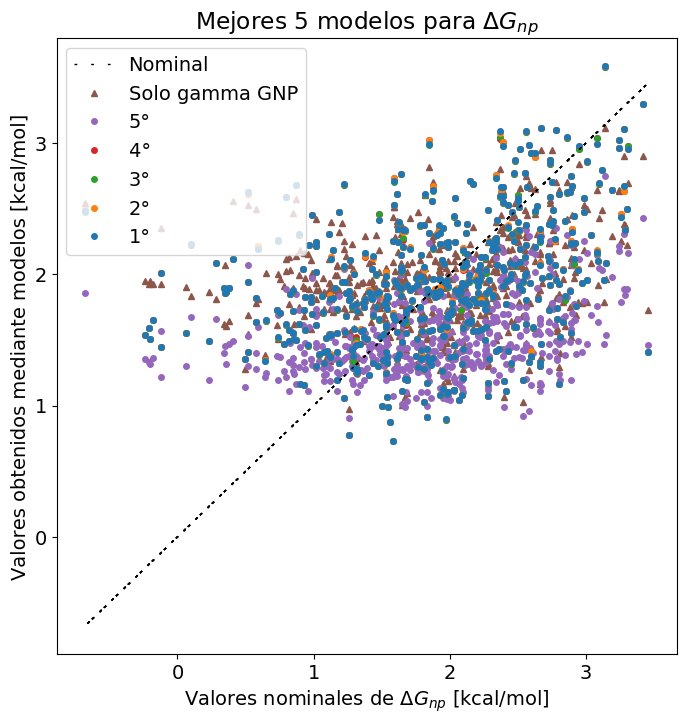

Por Pearson
SoloGamma obtuvo el lugar: 544


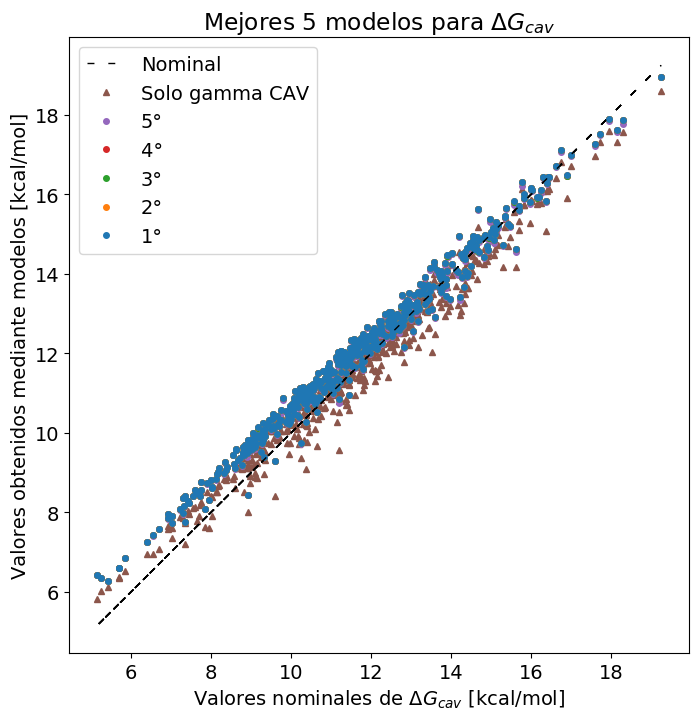

In [3]:
####### IMPORTING DATA FROM CREATED FILES #######

resultados_nespecies=np.load("resultados_nespecies.npy")
itinerario=np.load("itinerario.npy")
titulos=np.array(itinerario)

#################################################

plt.style.use("default")
for energy in ["gnp","cav"]:
    if energy=="gnp":
        b=nominales
        titulox="$\Delta G_{np}$"
        titulo_pdf="gnp"
        dd=(2,10)
    else:
        b=nominales2
        titulox="$\Delta G_{cav}$"
        titulo_pdf="cav"
        dd=(5,10)
    bb=np.reshape(b,(len(b),1))
    errores=abs((resultados_nespecies-bb)/bb)*100
    desviacion=(resultados_nespecies-bb)**2

    desviacion_metodos=(np.average(desviacion,axis=0)**0.5)
    errores_metodos=np.average(errores,axis=0)
    pearsons=np.zeros((len(resultados_nespecies.T),2))
    for i,r in enumerate(resultados_nespecies.T):
        pearsons[i]=np.array(stats.pearsonr(r,np.reshape(b,len(b))))

    lugares=np.argsort(pearsons[:,0])[::-1];print("Por Pearson")
    #lugares=np.argsort(desviacion_metodos);print("Por desviacion")
    #lugares=np.argsort(errores_metodos);print("Por Error")

    p_o=pearsons[lugares]
    t_o=titulos[lugares]
    e_o=errores_metodos[lugares]
    d_o=desviacion_metodos[lugares]
    r_o=resultados_nespecies[:,lugares]

    n_top=5

    xl=8
    mm=4
    
    lw=1
    f1=plt.figure(figsize=(xl,xl))
    plt.rcParams.update({'font.size': 14})
    f1=plt.plot(b,b,label="Nominal",linestyle="-",color="k", dashes=dd,markersize=mm,linewidth=lw)
    f1=plt.ylabel("Valores obtenidos mediante modelos [kcal/mol]")
    f1=plt.xlabel("Valores nominales de "+titulox+" [kcal/mol]")
    f1=plt.title("Mejores "+str(n_top)+" modelos para "+titulox)
    f1=plt.legend(loc="upper left")
    gamma_simbol="^"
    if energy=="gnp":
        dsg1=int(np.where(t_o=="SoloGamma_gnp")[0])
        f1=plt.plot(b,r_o[:,dsg1],gamma_simbol,label="Solo gamma GNP",color="C5",markersize=mm)
        p_o_gnp=p_o
        t_o_gnp=t_o
        e_o_gnp=e_o
        d_o_gnp=d_o
        r_o_gnp=r_o
    else:
        p_o_cav=p_o
        t_o_cav=t_o
        e_o_cav=e_o
        d_o_cav=d_o
        r_o_cav=r_o
        dsg1=int(np.where(t_o=="SoloGamma_cav")[0])
        f1=plt.plot(b,r_o[:,dsg1],gamma_simbol,label="Solo gamma CAV",color="C5",markersize=mm)
    f1=plt.plot(b,b,linestyle="-",color="k", dashes=dd,markersize=mm,linewidth=lw)
    f1=plt.legend(loc="upper left")
    f1=plt.savefig("mejores_resultados_"+titulo_pdf+str(0)+".svg",bbox_inches='tight')

    for i in range(n_top):
        i=n_top-i-1
        f1=plt.plot(b,r_o[:,i],"o",label=str(i+1)+"°",color="C"+str(i),markersize=mm)
        f1=plt.plot(b,b,linestyle="-",color="k", dashes=dd,markersize=mm,linewidth=lw)
        f1=plt.ylabel("Valores obtenidos mediante modelos [kcal/mol]")
        f1=plt.xlabel("Valores nominales de "+titulox+" [kcal/mol]")
        f1=plt.title("Mejores "+str(n_top)+" modelos para "+titulox)
        f1=plt.legend(loc="upper left")
        f1=plt.savefig("mejores_resultados_"+titulo_pdf+str(i+1)+".svg",bbox_inches='tight')

    index_label=[]
    for i in range(n_top):
        index_label.append(str(i+1)+"$^\circ$")
        aux=[t_o[i],\
             p_o[i][0].round(4),\
             d_o[i].round(4),\
             e_o[i].round(2)]
        if i==0:
            aux2=np.array(aux)
        else:
            aux2=np.vstack((aux2,aux))
    aux3=[t_o[dsg1],\
             p_o[dsg1][0].round(4),\
             d_o[dsg1].round(4),\
             e_o[dsg1].round(2)] 
    aux2=np.vstack((aux2,aux3))
    index_label.append(str(int(dsg1)+1)+u'\N{DEGREE SIGN}')

    df2 = pd.DataFrame(aux2,columns=['Modelo',"\u03C1","RECM",'%Error'],index=index_label)
    df2.to_excel("mejores"+energy+".xlsx")
    
    df2.to_html()

    f1=plt.ylabel("Valores obtenidos mediante modelos [kcal/mol]")
    f1=plt.xlabel("Valores nominales de "+titulox+" [kcal/mol]")
    f1=plt.title("Mejores "+str(n_top)+" modelos para "+titulox)
    print("SoloGamma obtuvo el lugar:",int(dsg1)+1)
    
    f1=plt.legend(loc="upper left")
    f1=plt.savefig("mejores_resultados_"+titulo_pdf+".svg",bbox_inches='tight')
    f1=plt.show()

## Correlation factor
I analyze the importance of each of the factors considered within the 1442 modes through the average correlation that these factors generate.

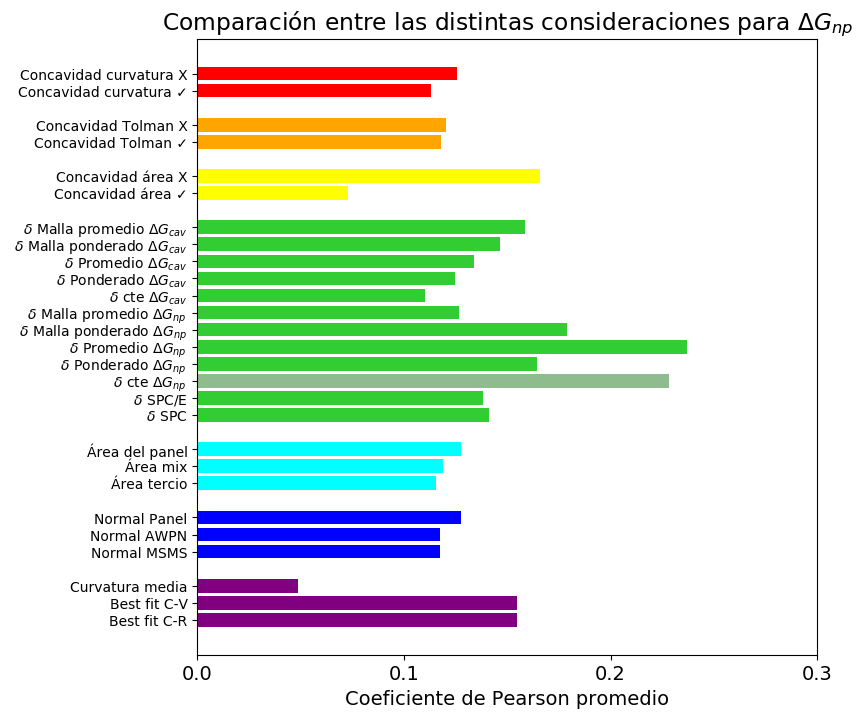

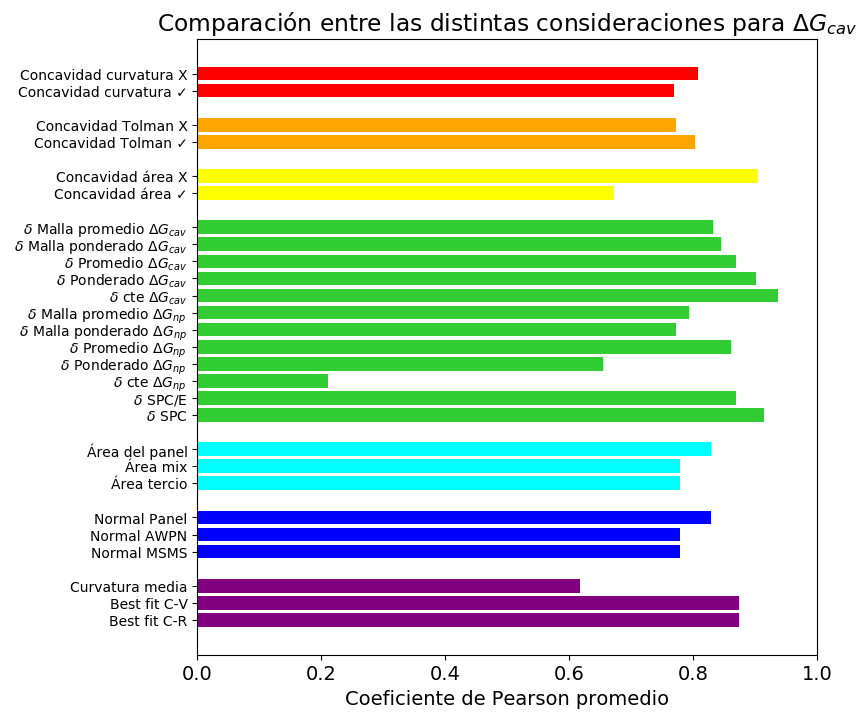

In [4]:
delta=" $\delta$ "
gnp=" $\Delta G_{np}$ "
cav=" $\Delta G_{cav}$ "
for en in ["gnp","cav"]:
    if en=="gnp":
        p_o=p_o_gnp
        t_o=t_o_gnp
        e_o=e_o_gnp
        d_o=d_o_gnp
        r_o=r_o_gnp
        tipo_en="$\Delta G_{np}$"
    else:
        p_o=p_o_cav
        t_o=t_o_cav
        e_o=e_o_cav
        d_o=d_o_cav
        r_o=r_o_cav
        tipo_en="$\Delta G_{cav}$"
    dick=dict()

    for i,name in enumerate(t_o):
        dato=p_o[:,0][i]
        #dato=d_o[i]
        corre=name.split("-")
        for j,entry in enumerate(corre):
            if entry in dick:
                dick[entry]+=np.array([dato,1])
            else:
                dick[entry]=np.array([dato,1])

    n_categorias=len(menu)
    n_items=len(np.concatenate(menu))

    colores_primarios=["red","orange","yellow","limegreen","cyan","blue","purple"][::-1]
    color_array=[]
    mejora=[]
    for i,m in enumerate(menu):
        for j,name in enumerate(m):
            mejora.append(i)
            color_array.append(colores_primarios[i])
            if i==0 and j==0:
                llaves=np.array([name])
                secret=np.array([dick[name]])
            else:
                llaves=np.vstack((llaves,np.array([name])))
                secret=np.vstack((secret,np.array([dick[name]])))
    r_secret=secret[:,0]/secret[:,1]
    color_array=np.where(r_secret<0,"darkseagreen",color_array)
    r_secret=np.where(r_secret<0,abs(r_secret),r_secret)
    index=np.arange(n_items)+mejora
    xl=8
    
    plt.figure(figsize=(xl,xl))
    plt.rcParams.update({'font.size': 14})
    mx=1
    
    plt.barh(index*mx,r_secret,color=color_array)
    #print(llaves)
    llaves=["Best fit C-R","Best fit C-V","Curvatura media",\
            "Normal MSMS","Normal AWPN","Normal Panel",\
            "Área tercio","Área mix","Área del panel",\
            delta+"SPC",delta+"SPC/E",\
            delta+"cte"+gnp,delta+"Ponderado"+gnp,delta+"Promedio"+gnp,delta+"Malla ponderado"+gnp,delta+"Malla promedio"+gnp,\
            delta+"cte"+cav,delta+"Ponderado"+cav,delta+"Promedio"+cav,delta+"Malla ponderado"+cav,delta+"Malla promedio"+cav,\
            "Concavidad área \u2713","Concavidad área X",\
            "Concavidad Tolman \u2713","Concavidad Tolman X",\
            "Concavidad curvatura \u2713","Concavidad curvatura X"]
    plt.yticks(index*mx, llaves, fontsize=10, rotation=0)
    if en=="cav":
        plt.xticks([0,0.2,0.4,0.6,0.8,1])
    else:
        plt.xticks([0,0.1,0.2,0.3])
    plt.xlabel("Coeficiente de Pearson promedio")
    plt.title("Comparación entre las distintas consideraciones para "+tipo_en)
    plt.savefig("comparaciones"+en+".svg",bbox_inches='tight')
    #plt.savefig('comparaciones.pdf',bbox_inches='tight')
    plt.show()